# PART-1 ( Panorama Using OpenCV)

## =>  See the attached slides before you start the assignment. 

####  Feel free to use any OpenCV function you want for this part. You've to implement a total of 3 tasks for this part. Task 4 is a bonus task. Don't copy code from google. 

In [9]:
import matplotlib
import cv2 as cv
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
%matplotlib notebook

## Task 1

### We'll start by taking two images from your mobile phone camera by standing at the same location and rotating the camera between two images. Now, your job is to stitch these two images together to make a panorama. In this task, implement a function to detect the key points using local variant descriptors and extract the features. 
### Define your own functions to implement this part but make sure that the arguments of your function are two images (Image1 , Image2) and return value for this part is a tuple of two lists of detected features(features_img1 , features_img2). Do not forget to visualize the detected features.

#### Hint : You can use SIFT/SURF feature detectors or some corner detector(e.g. harris corner detector). Opencv has built-in functions for these. 

In [10]:
nddraw_params = dict(keyColor = (255,0,0), # draw matches in green color
                   singlePointColor = (255,0,0),
#                    matchesMask = matchesMask, # draw only inliers
                   flags = 2)
Image_list = []
descriptor = []
kp_list = []



def myFunc(img1,img2):
    global Image_list,descriptor,kp_list
    Image_list = []
    descriptor = []
    kp_list = []
    sift = cv.xfeatures2d.SIFT_create()
    kp,des = sift.detectAndCompute(img1,None) 
    img_1= cv.drawKeypoints(img1,kp,None,color = (255,0,0))
    kp2,des2 = sift.detectAndCompute(img2,None)
    img_2 = cv.drawKeypoints(img2,kp,None,color = (255,0,0)) 
    Image_list.append(img_1)
    Image_list.append(img_2)
    descriptor.append(des)
    descriptor.append(des2)
    kp_list.append(kp)
    kp_list.append(kp2)

#     plt.figure()


#     plt.imshow(img_2)
    
#     plt.show()
#     plt.figure()

    
#     plt.imshow(img_1)
#     plt.show()
    
#     plt.imshow(des1)
#  reference:
# https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html

<IPython.core.display.Javascript object>


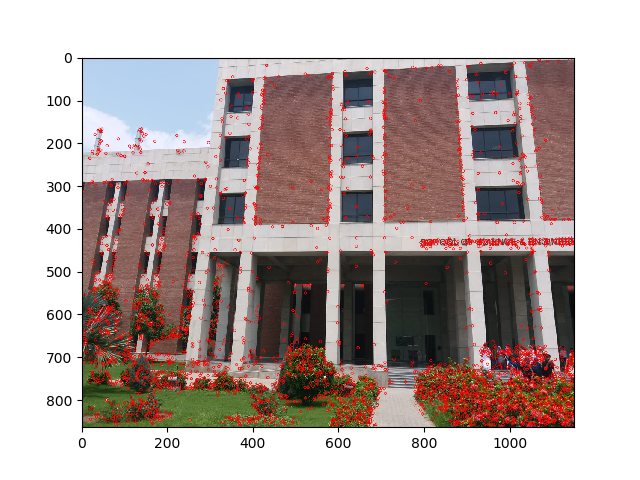

<IPython.core.display.Javascript object>


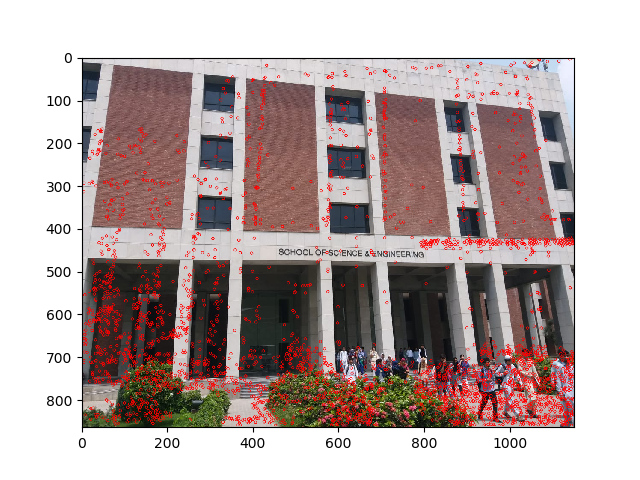

In [11]:
img1 = cv.cvtColor(cv.imread('./img.jpeg'), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread('./img1.jpeg'), cv.COLOR_BGR2RGB)

myFunc(img1,img2)
plt.figure()
plt.imshow(Image_list[0])
plt.show()

# plt.figure()
plt.figure()
plt.imshow(Image_list[1])
plt.show()



## Task 2

### Well done!! Now, you can use the detected features to find the matches between two images. Match features between the two images using a descriptor matcher of your own choice. By this point, you must have got correspondences between your two images. Visualize these correspondences between two images side by side. After you're done with matching, use these matched points to find the homography between these two images. 

### Input for this task is the output from previous task i.e. detected features(features_img1 , features_img2). Return value for this task must be a tuple containing a list of matched points and homography (matched_points , H)

#### Hint : Use RANSAC to find this homography. You can use findhomography function that is already implemented in OpenCV and RANSAC can be passed as an argument. Play with different threshold values and analyze the effect on the overall matching.

In [5]:
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
# #                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)
def matcher(ft_img1,ft_img2):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptor[0],descriptor[1], k=2)
    good = []
    newgood = []
    for m in matches:
        if m[0].distance < 0.5*m[1].distance:
            good.append(m)
    matches = np.asarray(good)
    if len(matches[:,0]) >= 4:
        src_pts = np.float32([ kp_list[0][m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_list[1][m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        print (H)
        



#     else: raise Exception("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
#     src_pts = np.float32([ kp_list[0][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
#     dst_pts = np.float32([ kp_list[1][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
#     Homog,ho = cv.findHomography(Image_list[0],Image_list[1],cv.RANSAC,2.0)
#     print Image_list[0].shape
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
#                    matchesMask = matches, # draw only inliers
                   flags = 2)
    image = cv.drawMatchesKnn(ft_img1,kp_list[0],ft_img2,kp_list[1],good,None,**draw_params)
    return [image,H]



# Ref
# https://docs.opencv.org/3.4.3/dc/dc3/tutorial_py_matcher.html
# https://stackoverflow.com/questions/50945385/python-opencv-findhomography-inputs

[[ 1.49793435e+00 -7.16699346e-02 -5.40491821e+02]
 [ 2.44413155e-01  1.29308959e+00 -1.41811899e+02]
 [ 4.61358616e-04 -4.91914733e-05  1.00000000e+00]]


<IPython.core.display.Javascript object>


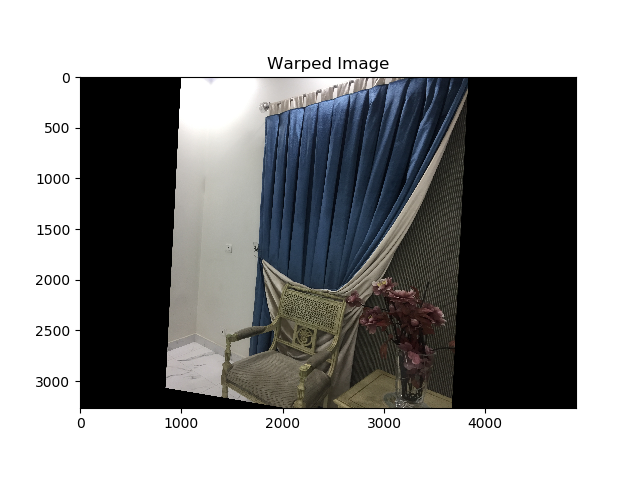

In [12]:
Matched_image,H = matcher(Image_list[0],Image_list[1])
plt.figure()
plt.imshow(Matched_image)
plt.show()

## Task 3

### Good. You're almost an OpenCV developer now. Just apply the perspective warp to stitch these images together. 

### Call the above two functions in this part and apply the homography obtained from task 2 to align the two images on the same plane. Input for this part are two image and utput for this part must be a stitched image. Do not forget to visualize the resulting panorama before you return.

#### Hint : You can use warpperspective function for this task.

[[ 8.15341397e-01 -4.75272938e-02  9.97887251e+02]
 [-1.29281941e-01  9.36272323e-01  8.03628038e+00]
 [-9.11867869e-05 -1.21985104e-07  1.00000000e+00]]


<IPython.core.display.Javascript object>


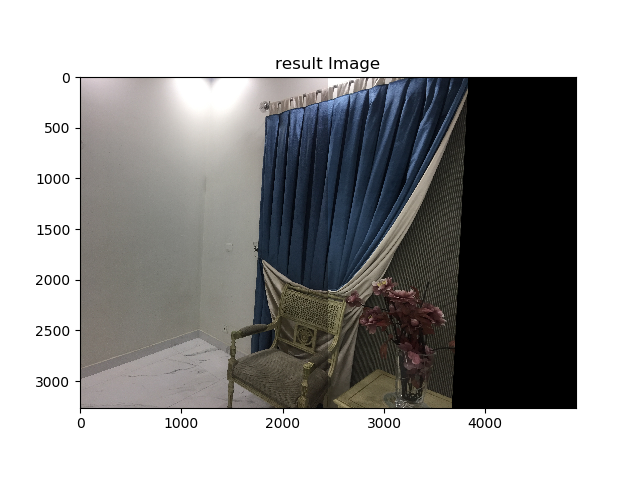

In [13]:
img1 = cv.cvtColor(cv.imread('./i2.jpg'), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread('./i1.jpg'), cv.COLOR_BGR2RGB)

myFunc(img1,img2)
Matched_image,H = matcher(Image_list[0],Image_list[1])
result = cv.warpPerspective(img1,H,(img1.shape[1] + img2.shape[1],img2.shape[0]))
newresult = result
final = np.ones
M = np.float32([[1,0,2400],[0,1,0]])
dst = cv.warpAffine(result,M,(result.shape[1],result.shape[0]))
plt.imshow(result)
plt.title("Warped Image")
plt.show()
plt.figure()
result[0:img2.shape[0], 0:img2.shape[1]] = img2
plt.title("result Image")


plt.imshow(result)

plt.show()
# dst[0:img.shape[0], 0:img.shape[1]] = img

# plt.figure()


# plt.imshow(result)

# plt.show()
# https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83

## Task 4 [Bonus]

### Practical panoramas	require	more than two images to	cover a	large enough field of view.	Use	the	stitching	algorithm above	to stitch multiple images together.	Suppose you are given a folder containing multiple images and your job is to stitch all these images together to make a single stitched panorama image. 

### Input for this task is a path to the folder containing images and output of this task must be the stitched image. Visualize the stitched image before you return.

#### Just as you applied the homography on one of the images to align them on the same plane in task 3, keep doing this for all images so that all of them are alligned on the same plane.

In [14]:
## Write Code Here